In [17]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize=(15, 10)
export_dir = './plots/'
data_dir = '/home/yuxin/ray_results/PPO/PPO_meltingpot_'
env_name = 'prisoners_dilemma'
env_list = ['Prisoners_Dilemma_S_5M','Prisoners_Dilemma_M_5M','Prisoners_Dilemma_L_5M','Prisoners_Dilemma_O_5M']
total_timestep = 6e6

sns.set()
sns.set_context("talk")

In [18]:
def get_section_results(file, env_name, *tags):
    data_dict = {'env_step': [], 'env_name': []}
    data_dict.update({tag: [] for tag in tags})
    max_step = -1
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    if max_step < e.step:
                        max_step = e.step
                        data_dict['env_step'].append(e.step)
                        data_dict['env_name'].append(env_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

In [19]:
def read_evaluation_data(env_list, size, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for env in env_list:
        logdir = os.path.join(data_dir+env, 'events*')
        print(logdir)
        eventfile = glob.glob(logdir)[0]
        data_dict = get_section_results(eventfile, env, 'ray/tune/episode_reward_min',
                                        'ray/tune/episode_reward_mean','ray/tune/episode_reward_max')
        data = pd.DataFrame(data_dict)
        for (columnName, columnData) in data.items():
            if columnName != 'env_step' and columnName != 'env_name':
                data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

        # reduce size for plotting
        count_row = data.shape[0]
        reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
        data_p = data.iloc[reduced_row]

        full_data = pd.concat([full_data, data], axis=0)
        plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

In [20]:
data, data_plot = read_evaluation_data(env_list, 500, 0.2)

/home/yuxin/ray_results/PPO/PPO_meltingpot_Prisoners_Dilemma_S_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Prisoners_Dilemma_M_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Prisoners_Dilemma_L_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Prisoners_Dilemma_O_5M/events*


In [21]:
data_plot

,env_step,env_name,ray/tune/episode_reward_min,ray/tune/episode_reward_mean,ray/tune/episode_reward_max,ray/tune/episode_reward_min_smooth,ray/tune/episode_reward_mean_smooth,ray/tune/episode_reward_max_smooth
0,4800,Prisoners_Dilemma_S_5M,81.288887,90.473412,99.657936,81.288887,90.473412,99.657936
6,14400,Prisoners_Dilemma_S_5M,54.401588,69.565399,99.657936,58.415021,73.787291,99.657936
12,24000,Prisoners_Dilemma_S_5M,40.118519,70.922897,113.101295,47.844774,69.920258,102.503018
18,33600,Prisoners_Dilemma_S_5M,40.118519,72.048897,113.101295,42.060551,70.520341,110.437367
25,44800,Prisoners_Dilemma_S_5M,40.118519,79.091652,189.214233,40.521140,74.569599,140.032733
...,...,...,...,...,...,...,...,...
3097,4958400,Prisoners_Dilemma_O_5M,13.004273,52.120548,131.957809,13.004275,51.822902,132.351545
3104,4969600,Prisoners_Dilemma_O_5M,13.004273,53.153790,131.957809,13.004274,52.585306,132.040382
3110,4979200,Prisoners_Dilemma_O_5M,13.004273,53.441261,131.957809,13.004274,53.291138,131.979455
3116,4988800,Prisoners_Dilemma_O_5M,13.004273,54.627487,128.725082,13.004273,54.017253,130.054882


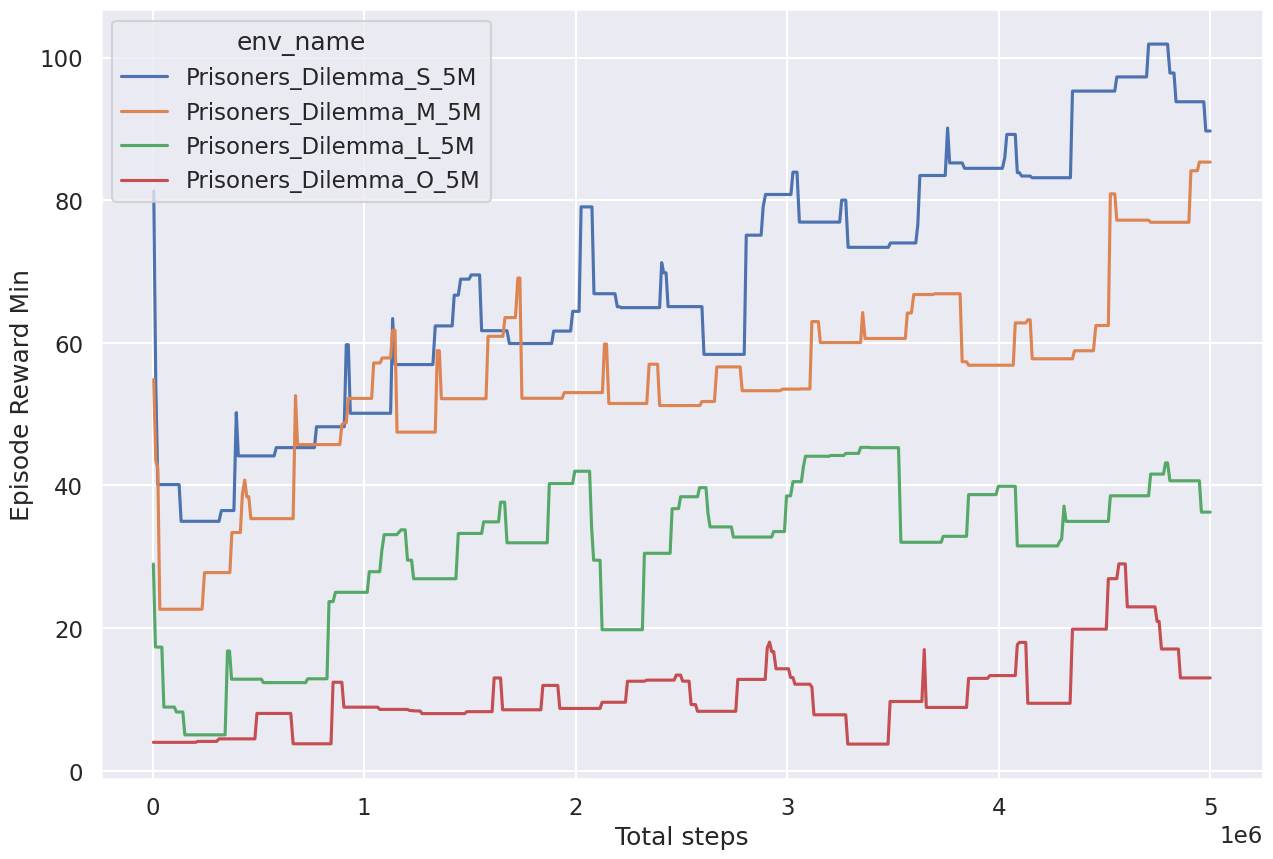

In [22]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_min', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Min')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+'_ep_reward_min.pdf'), bbox_inches='tight')

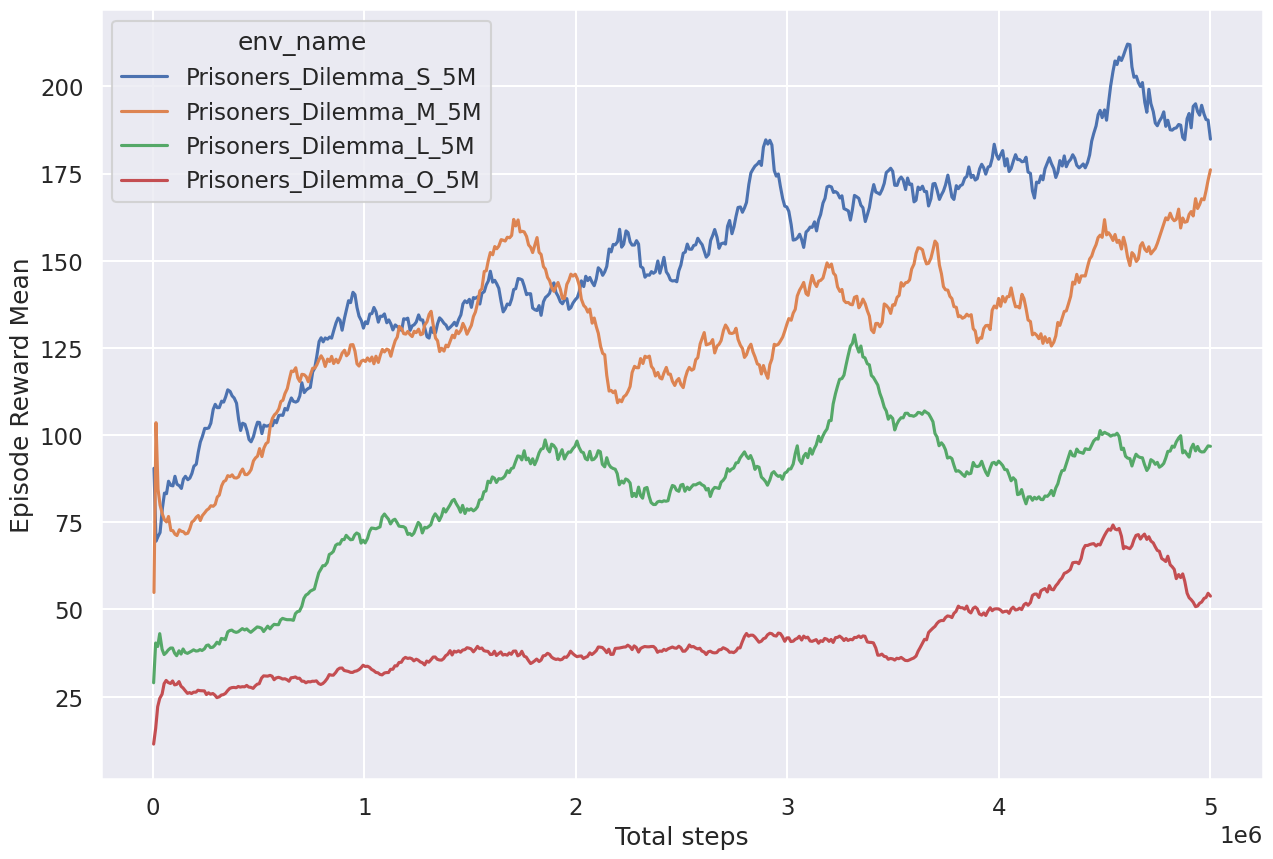

In [23]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_mean', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Mean')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+'_ep_reward_mean.pdf'), bbox_inches='tight')

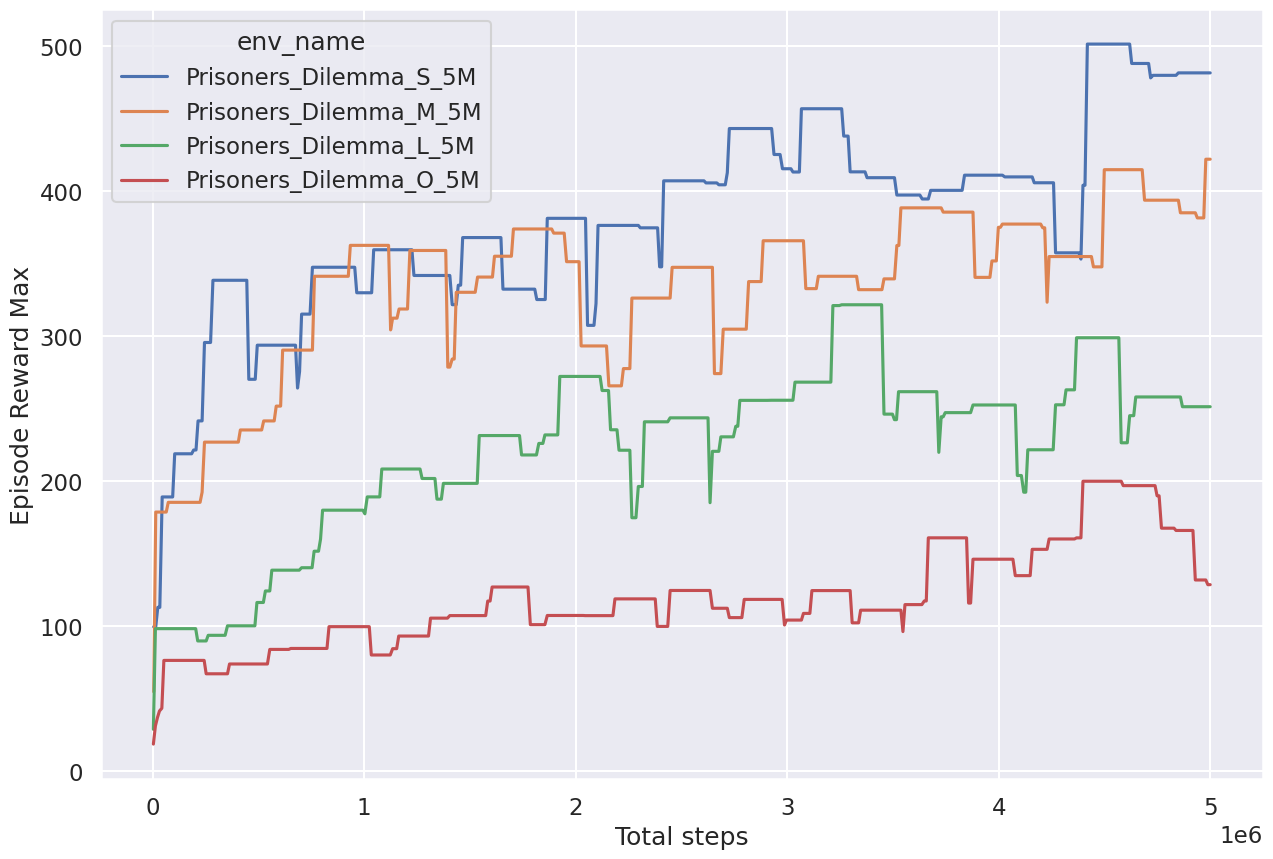

In [24]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_max', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Max')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+'_ep_reward_max.pdf'), bbox_inches='tight')